# CAPTCHA Solver - End-to-end CNN Approach

## Introduction

I want to create an end-to-end model that predicts the three letters given a CAPTCHA image that looks like this:

![](dataset/train/abc_0f8b2c3a-4441-447c-922c-9696e63eaf28.png)

Typical solutions I have found include a pre-processing step where each character is segmented as its own image. Then, it is used as an input to a CNN model to determine the most probable character the image represents. This approach will not work very well for images where characters are distorted in some fashion.

## Model architecture

After doing some research into this problem, Geetika Garg created a [presentation](http://www.cs.sjsu.edu/faculty/pollett/masters/Semesters/Spring15/geetika/CS298%20Slides%20-%20PDF) about a CAPTCHA cracker. In particular, in slide 33, the fixed length model using CNN proved to be effective in solving this architecture problem that I have.

![](documentation/img/garg_cnn_architecture.png)
**Figure 1:** Garg's fixed model CNN architecture

In **Figure 1**, Garg's model architecture contains _n_ dense layers and softmax layers. Each combination focuses on a different letter in the image. This is similar to the idea of segmenting image per character before running it through a CNN model. In this case, it is built into the model architecture itself.

Note that after taking a look at the [open source code](https://github.com/bgeetika/Captcha-Decoder/) of Garg, I found that only dense layers are created *n* times and the output of each layers are stacked as one input into the softmax layer.

## Implementation

### Imports and constants

Here are the imports and constants that will be used throughout the implementation section of this notebook.

In [42]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# sci-kit learn
from sklearn.model_selection import train_test_split

# pandas
import pandas as pd

# tqdm
from tqdm import tqdm_notebook

# PIL
from PIL import Image

# Matplotlib
import matplotlib.pyplot as plt

# NumPy
import numpy as np

In [2]:
# Filepaths
TRAIN_FILEPATH = "dataset/train/{}"
TEST_FILEPATH = "dataset/test/{}"

# Model checkpointing
CAPTCHACNNCLASSIFIER_MODEL_CHECKPOINT_FILEPATH = "models/checkpoints/CAPTCHACNNClassifier_epoch{}.pt"

# Accuracies and losses filepath for plotting
CAPTCHACNNCLASSIFIER_TRAIN_ACCURACIES_FILEPATH = "documentation/CAPTCHACNNClassifier_epoch{}_train_acc.png"
CAPTCHACNNCLASSIFIER_TRAIN_LOSSES_FILEPATH = "documentation/CAPTCHACNNClassifier_epoch{}_train_loss.png"
CAPTCHACNNCLASSIFIER_VALID_ACCURACIES_FILEPATH = "documentation/CAPTCHACNNClassifier_epoch{}_valid_acc.png"
CAPTCHACNNCLASSIFIER_VALID_LOSSES_FILEPATH = "documentation/CAPTCHACNNClassifier_epoch{}_valid_loss.png"

# Dynamically determining the device to use for tensors and models
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image size to resize input images to
IMG_SIZE = (100, 100)

# Model checkpointing
MODEL_KEY = "model"
OPTIMIZER_KEY = "optimizer"
TRAINING_LOSSES_KEY = "training_losses"
VALIDATION_LOSSES_KEY = "validation_losses"
TRAINING_ACCURACIES_KEY = "training_accuracies"
VALIDATION_ACCURACIES_KEY = "validation_accuracies"

# Model training and evaluation
NUM_CHARS = 3
LR = 1e-1
MOMENTUM = 0.85
TRAINING_BATCH_SIZE = 1024
EPOCHS = 100

### Dataset

Let's define a `Vocabulary` class which will determine the conversion of each character to its equivalent index and vice-versa. Also, a helper method has been written to convert prediction indices to its character equivalent.

In [3]:
class Vocabulary:
    def __init__(self):
        self.labels_to_idx = {chr(char): idx for idx, char in enumerate(range(ord("a"), ord("z") + 1))}
        self.idx_to_labels = {self.labels_to_idx[char]: char for char in self.labels_to_idx}

    def convert_indices_to_sequences(self, indices):
        return "".join([self.idx_to_labels[idx.data.item()] for idx in indices])

Next, let's define three datasets: `TrainingDataset`, `ValidationDataset`, and `TestDataset`. Note that `ValidationDataset` will be created by taking 10% from the training dataset.

In [4]:
class TrainingDataset(Dataset):
    def __init__(self, inputs, labels, vocabulary, filepath):
        self.inputs = inputs
        self.labels = labels
        self.vocabulary = vocabulary

        self.filepath = filepath

        self.transforms = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self): 
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.convert_sample_to_tensor(idx)

    def convert_sample_to_tensor(self, idx):
        input = self.inputs[idx]
        input = Image.open(self.filepath.format(input))
        input = self.transforms(input)

        label = self.labels[idx]
        label = [self.vocabulary.labels_to_idx[char] for char in label]
        label = torch.LongTensor(label)

        return input, label

class ValidationDataset(TrainingDataset):
    def __init__(self, inputs, labels, vocabulary, filepath):
        super(ValidationDataset, self).__init__(inputs, labels, vocabulary, filepath)

class TestDataset(TrainingDataset):
    def __init__(self, inputs, labels, vocabulary, filepath):
        super(TestDataset, self).__init__(inputs, labels, vocabulary, filepath)

Note that transformations such as `Grayscale` and `Resize` have been applied before the image is turned into tensors with values between 0 and 1. In particular, grayscaling the image helps the model to focus on the stroke of what a specific character looks like. By having an RGB channel does not change anything about the model's performance. It only adds more parameters to our model in comparison of using a grayscale channel image.

After defining the datasets that will be used, let's create a helper function to open and create these subclass for usage when training and evaluating our model.

In [5]:
def open_create_datasets(vocab):
    training_ds_df = pd.read_csv(TRAIN_FILEPATH.format("train.csv"))
    test_ds_df = pd.read_csv(TEST_FILEPATH.format("test.csv"))

    # Split training set to training and validation sets
    training_inputs, validation_inputs, training_labels, validation_labels = train_test_split(training_ds_df.inputs.values.tolist(), training_ds_df.labels.values.tolist(), test_size=0.1, random_state=42)

    training_ds = TrainingDataset(training_inputs, training_labels, vocab, TRAIN_FILEPATH)
    validation_ds = ValidationDataset(validation_inputs, validation_labels, vocab, TRAIN_FILEPATH)
    test_ds = TestDataset(test_ds_df.inputs.values.tolist(), test_ds_df.labels.values.tolist(), vocab, TEST_FILEPATH)

    return training_ds, validation_ds, test_ds

Next, let's create the datasets:

In [6]:
vocab = Vocabulary()
training_ds, validation_ds, test_ds = open_create_datasets(vocab)

Here are the number of samples in each dataset:

In [7]:
print("The training dataset has {} samples.".format(len(training_ds)))
print("The validation dataset has {} samples.".format(len(validation_ds)))
print("The test dataset has {} samples.\n".format(len(test_ds)))

The training dataset has 42120 samples.
The validation dataset has 4680 samples.
The test dataset has 15600 samples.



### Model architecture

First, I create an `Encoder` class which contains convolution and pooling layers.

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = self.create_encoder()

    def forward(self, x):
        x = self.encoder(x)
        return x

    def create_encoder(self):
        return nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

Next, the dense and softmax layers are added and an instance of the `Encoder` class is initialized to create the end-to-end CNN architecture.

In [9]:
class CAPTCHACNNClassifier(nn.Module):
    def __init__(self, num_letters, num_classes, device):
        super(CAPTCHACNNClassifier, self).__init__()

        self.num_letters = num_letters
        self.encoder = Encoder()
        self.linear = nn.Sequential(*[
            nn.Dropout(),
            nn.Linear(128 * 10 * 10, 512),
            nn.ReLU()
        ])
        self.linear_1 = nn.Sequential(*[
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU()
        ])
        self.linear_2 = nn.Sequential(*[
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU()
        ])
        self.linear_3 = nn.Sequential(*[
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU()
        ])
        self.classifier = nn.Sequential(*[
            nn.Dropout(), 
            nn.Linear(256, num_classes)
        ])

    def forward(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        x = self.linear(x)
        x = torch.stack([self.linear_1(x), self.linear_2(x), self.linear_3(x)], dim=1)
        x = self.classifier(x)
        return x

Note that `self.linear` is added for non-linearity after taking the output of the encoder. Dropout layers are taken from Garg's [open source code](https://github.com/bgeetika/Captcha-Decoder/). 

### Optimizer

The optimizer I use is **stochastic gradient descent** with a learning rate of `1e-1` and momentum of `0.85`. Note that PyTorch's momentum is the implementation from [Sutskever et. al](http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf) - in particular, the Nesterov Adaptive Gradient, which has the following update procedure:

![](documentation/img/nag.png)


The usage of momentum helps with (faster) convergence of the model. Initially, using SGD without momentum does not converge. So adding momentum helps a lot when it comes to model convergence.

### Loss function

The loss function I use in this problem is **cross-entropy** loss function since this is a multi-class classfication problem.

### Performance metric

As our metric of the model's performance, I will be using **accuracy**.

In [30]:
def calculate_accuracy(predictions, labels):
    predictions = nn.LogSoftmax(dim=1)(predictions)
    predictions = torch.max(predictions, dim=1)[1].view(-1)
    
    return torch.sum(predictions == labels.data).float() / len(labels)

### Training and evaluation loop

Before training and evaluating our model, let's write a helper function to help us do that.

In [29]:
def train_validate_model(model, optimizer, criterion, training_ds, validation_ds, checkpoint_model=False, training_ds_batch_size=64, validation_ds_batch_size=64, num_epochs=10):
    # Create dataloader for batching support of every dataset
    training_dl = DataLoader(training_ds, batch_size=training_ds_batch_size, shuffle=True, num_workers=4)
    validation_dl = DataLoader(validation_ds, batch_size=validation_ds_batch_size, num_workers=4)

    # This is used for tracking accuracies and losses for model checkpointing
    final_training_losses, final_validation_losses = [], []
    final_training_accuracies, final_validation_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        print("Starting epoch {}...".format(epoch))

        training_loss = 0.0
        training_accuracies = []
        
        # Start training model
        model.train()

        for inputs, labels in tqdm_notebook(training_dl, desc="[TRAINING]"):
            optimizer.zero_grad()

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            predictions = model(inputs)
            predictions = predictions.view(predictions.size(0) * predictions.size(1), -1)
            labels = labels.view(-1)
            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            training_loss += loss.item()
            training_accuracies.append(calculate_accuracy(predictions, labels).item())

        epoch_training_accuracy = sum(training_accuracies) / len(training_accuracies)
        epoch_training_loss = training_loss / len(training_dl)

        print("[TRAINING] Epoch {} loss is {:.4f}".format(epoch, epoch_training_loss))
        print("[TRAINING] Epoch {} accuracy is {:.4f}".format(epoch, epoch_training_accuracy))

        validation_loss = 0.0
        validation_accuracies = []

        # Evaluate the model
        model.eval()
        
        with torch.no_grad():
            for inputs, labels in tqdm_notebook(validation_dl, desc="[VALIDATION]"):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                predictions = model(inputs)
                predictions = predictions.view(predictions.size(0) * predictions.size(1), -1)
                labels = labels.view(-1)
                loss = criterion(predictions, labels)

                validation_loss += loss.item()
                validation_accuracies.append(calculate_accuracy(predictions, labels).item())

        epoch_validation_accuracy = sum(validation_accuracies) / len(validation_accuracies)
        epoch_validation_loss = validation_loss / len(validation_dl)

        print("[VALIDATION] Epoch {} loss is {:.4f}".format(epoch, epoch_validation_loss))
        print("[VALIDATION] Epoch {} accuracy is {:.4f}\n".format(epoch, epoch_validation_accuracy))

        if checkpoint_model:
            final_training_accuracies.append(epoch_training_accuracy)
            final_training_losses.append(epoch_training_loss)
            final_validation_accuracies.append(epoch_validation_accuracy)
            final_validation_losses.append(epoch_validation_loss)

        print("Completed epoch {}!\n".format(epoch))

    if checkpoint_model:
        save_model_checkpoint(
            model, 
            optimizer, 
            final_training_losses, 
            final_validation_losses, 
            final_training_accuracies, 
            final_validation_accuracies, 
            CAPTCHACNNCLASSIFIER_MODEL_CHECKPOINT_FILEPATH.format(epoch)
        )

### Model checkpointing

In addition, let's add some helper functions to checkpoint our models.

In [12]:
def save_model_checkpoint(model, optimizer, training_losses, validation_losses, training_accuracies, validation_accuracies, filepath):
    model_checkpoint = {
        MODEL_KEY: model.state_dict(),
        OPTIMIZER_KEY: optimizer.state_dict(), 
        TRAINING_LOSSES_KEY: training_losses, 
        VALIDATION_LOSSES_KEY: validation_losses,
        TRAINING_ACCURACIES_KEY: training_accuracies,
        VALIDATION_ACCURACIES_KEY: validation_accuracies
    }

    torch.save(model_checkpoint, filepath)

def load_model_checkpoint(model, optimizer, filepath):
    model_checkpoint = torch.load(filepath)
    model.load_state_dict(model_checkpoint[MODEL_KEY])
    optimizer.load_state_dict(model_checkpoint[OPTIMIZER_KEY])

    return model, optimizer, model_checkpoint[TRAINING_LOSSES_KEY], model_checkpoint[VALIDATION_LOSSES_KEY], model_checkpoint[TRAINING_ACCURACIES_KEY], model_checkpoint[VALIDATION_ACCURACIES_KEY]

### Putting it all together

Now we can proceed with initializing our model, optimizer, and loss function to start the training and evaluation of our model. Note that the model is trained for **100 epochs** with training batch size of **1024**.

In [13]:
captcha_cnn_classifier = CAPTCHACNNClassifier(NUM_CHARS, len(vocab.labels_to_idx), DEVICE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(captcha_cnn_classifier.parameters(), lr=LR, momentum=MOMENTUM)

Let's train the model. Note that under `models/checkpoints` there is already a pre-trained model. As a result, the line of code below has been commented. Uncomment this line of code to train from scratch. Ensure that `checkpoint_model` is set accordingly.

In [72]:
#train_validate_model(captcha_cnn_classifier, optimizer, criterion, training_ds, validation_ds, training_ds_batch_size=TRAINING_BATCH_SIZE, num_epochs=EPOCHS, checkpoint_model=True)

Starting epoch 1...


[TRAINING] Epoch 1 loss is 3.2586
[TRAINING] Epoch 1 accuracy is 0.0385


[VALIDATION] Epoch 1 loss is 3.2584
[VALIDATION] Epoch 1 accuracy is 0.0372

Completed epoch 1!

Starting epoch 2...


[TRAINING] Epoch 2 loss is 3.2583
[TRAINING] Epoch 2 accuracy is 0.0390


[VALIDATION] Epoch 2 loss is 3.2583
[VALIDATION] Epoch 2 accuracy is 0.0389

Completed epoch 2!

Starting epoch 3...


[TRAINING] Epoch 3 loss is 3.2581
[TRAINING] Epoch 3 accuracy is 0.0398


[VALIDATION] Epoch 3 loss is 3.2581
[VALIDATION] Epoch 3 accuracy is 0.0422

Completed epoch 3!

Starting epoch 4...


[TRAINING] Epoch 4 loss is 3.2579
[TRAINING] Epoch 4 accuracy is 0.0403


[VALIDATION] Epoch 4 loss is 3.2579
[VALIDATION] Epoch 4 accuracy is 0.0364

Completed epoch 4!

Starting epoch 5...


[TRAINING] Epoch 5 loss is 3.2577
[TRAINING] Epoch 5 accuracy is 0.0413


[VALIDATION] Epoch 5 loss is 3.2575
[VALIDATION] Epoch 5 accuracy is 0.0398

Completed epoch 5!

Starting epoch 6...


[TRAINING] Epoch 6 loss is 3.2571
[TRAINING] Epoch 6 accuracy is 0.0438


[VALIDATION] Epoch 6 loss is 3.2565
[VALIDATION] Epoch 6 accuracy is 0.0589

Completed epoch 6!

Starting epoch 7...


[TRAINING] Epoch 7 loss is 3.2556
[TRAINING] Epoch 7 accuracy is 0.0495


[VALIDATION] Epoch 7 loss is 3.2536
[VALIDATION] Epoch 7 accuracy is 0.1159

Completed epoch 7!

Starting epoch 8...


[TRAINING] Epoch 8 loss is 3.2502
[TRAINING] Epoch 8 accuracy is 0.0618


[VALIDATION] Epoch 8 loss is 3.2386
[VALIDATION] Epoch 8 accuracy is 0.1989

Completed epoch 8!

Starting epoch 9...


[TRAINING] Epoch 9 loss is 3.1642
[TRAINING] Epoch 9 accuracy is 0.0986


[VALIDATION] Epoch 9 loss is 2.6441
[VALIDATION] Epoch 9 accuracy is 0.2724

Completed epoch 9!

Starting epoch 10...


[TRAINING] Epoch 10 loss is 2.3262
[TRAINING] Epoch 10 accuracy is 0.2825


[VALIDATION] Epoch 10 loss is 1.4172
[VALIDATION] Epoch 10 accuracy is 0.5698

Completed epoch 10!

Starting epoch 11...


[TRAINING] Epoch 11 loss is 2.5937
[TRAINING] Epoch 11 accuracy is 0.2420


[VALIDATION] Epoch 11 loss is 2.4326
[VALIDATION] Epoch 11 accuracy is 0.3806

Completed epoch 11!

Starting epoch 12...


[TRAINING] Epoch 12 loss is 1.7595
[TRAINING] Epoch 12 accuracy is 0.4243


[VALIDATION] Epoch 12 loss is 0.9944
[VALIDATION] Epoch 12 accuracy is 0.6911

Completed epoch 12!

Starting epoch 13...


[TRAINING] Epoch 13 loss is 1.2250
[TRAINING] Epoch 13 accuracy is 0.5799


[VALIDATION] Epoch 13 loss is 0.6695
[VALIDATION] Epoch 13 accuracy is 0.7978

Completed epoch 13!

Starting epoch 14...


[TRAINING] Epoch 14 loss is 0.9806
[TRAINING] Epoch 14 accuracy is 0.6627


[VALIDATION] Epoch 14 loss is 0.5012
[VALIDATION] Epoch 14 accuracy is 0.8711

Completed epoch 14!

Starting epoch 15...


[TRAINING] Epoch 15 loss is 0.8253
[TRAINING] Epoch 15 accuracy is 0.7189


[VALIDATION] Epoch 15 loss is 0.4283
[VALIDATION] Epoch 15 accuracy is 0.8920

Completed epoch 15!

Starting epoch 16...


[TRAINING] Epoch 16 loss is 0.6941
[TRAINING] Epoch 16 accuracy is 0.7627


[VALIDATION] Epoch 16 loss is 0.3218
[VALIDATION] Epoch 16 accuracy is 0.9072

Completed epoch 16!

Starting epoch 17...


[TRAINING] Epoch 17 loss is 0.6181
[TRAINING] Epoch 17 accuracy is 0.7900


[VALIDATION] Epoch 17 loss is 0.2555
[VALIDATION] Epoch 17 accuracy is 0.9175

Completed epoch 17!

Starting epoch 18...


[TRAINING] Epoch 18 loss is 0.5345
[TRAINING] Epoch 18 accuracy is 0.8206


[VALIDATION] Epoch 18 loss is 0.2017
[VALIDATION] Epoch 18 accuracy is 0.9493

Completed epoch 18!

Starting epoch 19...


[TRAINING] Epoch 19 loss is 0.4664
[TRAINING] Epoch 19 accuracy is 0.8432


[VALIDATION] Epoch 19 loss is 0.1574
[VALIDATION] Epoch 19 accuracy is 0.9556

Completed epoch 19!

Starting epoch 20...


[TRAINING] Epoch 20 loss is 0.4180
[TRAINING] Epoch 20 accuracy is 0.8588


[VALIDATION] Epoch 20 loss is 0.1222
[VALIDATION] Epoch 20 accuracy is 0.9673

Completed epoch 20!

Starting epoch 21...


[TRAINING] Epoch 21 loss is 0.3687
[TRAINING] Epoch 21 accuracy is 0.8770


[VALIDATION] Epoch 21 loss is 0.1251
[VALIDATION] Epoch 21 accuracy is 0.9656

Completed epoch 21!

Starting epoch 22...


[TRAINING] Epoch 22 loss is 0.3427
[TRAINING] Epoch 22 accuracy is 0.8850


[VALIDATION] Epoch 22 loss is 0.1052
[VALIDATION] Epoch 22 accuracy is 0.9714

Completed epoch 22!

Starting epoch 23...


[TRAINING] Epoch 23 loss is 0.3196
[TRAINING] Epoch 23 accuracy is 0.8939


[VALIDATION] Epoch 23 loss is 0.0915
[VALIDATION] Epoch 23 accuracy is 0.9764

Completed epoch 23!

Starting epoch 24...


[TRAINING] Epoch 24 loss is 0.2889
[TRAINING] Epoch 24 accuracy is 0.9034


[VALIDATION] Epoch 24 loss is 0.0819
[VALIDATION] Epoch 24 accuracy is 0.9779

Completed epoch 24!

Starting epoch 25...


[TRAINING] Epoch 25 loss is 0.2663
[TRAINING] Epoch 25 accuracy is 0.9114


[VALIDATION] Epoch 25 loss is 0.0662
[VALIDATION] Epoch 25 accuracy is 0.9825

Completed epoch 25!

Starting epoch 26...


[TRAINING] Epoch 26 loss is 0.2437
[TRAINING] Epoch 26 accuracy is 0.9192


[VALIDATION] Epoch 26 loss is 0.0593
[VALIDATION] Epoch 26 accuracy is 0.9844

Completed epoch 26!

Starting epoch 27...


[TRAINING] Epoch 27 loss is 0.2280
[TRAINING] Epoch 27 accuracy is 0.9246


[VALIDATION] Epoch 27 loss is 0.0530
[VALIDATION] Epoch 27 accuracy is 0.9857

Completed epoch 27!

Starting epoch 28...


[TRAINING] Epoch 28 loss is 0.2091
[TRAINING] Epoch 28 accuracy is 0.9308


[VALIDATION] Epoch 28 loss is 0.0478
[VALIDATION] Epoch 28 accuracy is 0.9879

Completed epoch 28!

Starting epoch 29...


[TRAINING] Epoch 29 loss is 0.2031
[TRAINING] Epoch 29 accuracy is 0.9324


[VALIDATION] Epoch 29 loss is 0.0477
[VALIDATION] Epoch 29 accuracy is 0.9873

Completed epoch 29!

Starting epoch 30...


[TRAINING] Epoch 30 loss is 0.1866
[TRAINING] Epoch 30 accuracy is 0.9388


[VALIDATION] Epoch 30 loss is 0.0403
[VALIDATION] Epoch 30 accuracy is 0.9885

Completed epoch 30!

Starting epoch 31...


[TRAINING] Epoch 31 loss is 0.1742
[TRAINING] Epoch 31 accuracy is 0.9428


[VALIDATION] Epoch 31 loss is 0.0380
[VALIDATION] Epoch 31 accuracy is 0.9892

Completed epoch 31!

Starting epoch 32...


[TRAINING] Epoch 32 loss is 0.1688
[TRAINING] Epoch 32 accuracy is 0.9446


[VALIDATION] Epoch 32 loss is 0.0346
[VALIDATION] Epoch 32 accuracy is 0.9905

Completed epoch 32!

Starting epoch 33...


[TRAINING] Epoch 33 loss is 0.1547
[TRAINING] Epoch 33 accuracy is 0.9491


[VALIDATION] Epoch 33 loss is 0.0335
[VALIDATION] Epoch 33 accuracy is 0.9907

Completed epoch 33!

Starting epoch 34...


[TRAINING] Epoch 34 loss is 0.1494
[TRAINING] Epoch 34 accuracy is 0.9507


[VALIDATION] Epoch 34 loss is 0.0317
[VALIDATION] Epoch 34 accuracy is 0.9898

Completed epoch 34!

Starting epoch 35...


[TRAINING] Epoch 35 loss is 0.1385
[TRAINING] Epoch 35 accuracy is 0.9539


[VALIDATION] Epoch 35 loss is 0.0392
[VALIDATION] Epoch 35 accuracy is 0.9890

Completed epoch 35!

Starting epoch 36...


[TRAINING] Epoch 36 loss is 0.1797
[TRAINING] Epoch 36 accuracy is 0.9420


[VALIDATION] Epoch 36 loss is 0.0297
[VALIDATION] Epoch 36 accuracy is 0.9923

Completed epoch 36!

Starting epoch 37...


[TRAINING] Epoch 37 loss is 0.1277
[TRAINING] Epoch 37 accuracy is 0.9576


[VALIDATION] Epoch 37 loss is 0.0298
[VALIDATION] Epoch 37 accuracy is 0.9922

Completed epoch 37!

Starting epoch 38...


[TRAINING] Epoch 38 loss is 0.1219
[TRAINING] Epoch 38 accuracy is 0.9597


[VALIDATION] Epoch 38 loss is 0.0279
[VALIDATION] Epoch 38 accuracy is 0.9917

Completed epoch 38!

Starting epoch 39...


[TRAINING] Epoch 39 loss is 0.1209
[TRAINING] Epoch 39 accuracy is 0.9602


[VALIDATION] Epoch 39 loss is 0.0268
[VALIDATION] Epoch 39 accuracy is 0.9933

Completed epoch 39!

Starting epoch 40...


[TRAINING] Epoch 40 loss is 0.1145
[TRAINING] Epoch 40 accuracy is 0.9624


[VALIDATION] Epoch 40 loss is 0.0247
[VALIDATION] Epoch 40 accuracy is 0.9928

Completed epoch 40!

Starting epoch 41...


[TRAINING] Epoch 41 loss is 0.1091
[TRAINING] Epoch 41 accuracy is 0.9644


[VALIDATION] Epoch 41 loss is 0.0233
[VALIDATION] Epoch 41 accuracy is 0.9934

Completed epoch 41!

Starting epoch 42...


[TRAINING] Epoch 42 loss is 0.1036
[TRAINING] Epoch 42 accuracy is 0.9656


[VALIDATION] Epoch 42 loss is 0.0230
[VALIDATION] Epoch 42 accuracy is 0.9930

Completed epoch 42!

Starting epoch 43...


[TRAINING] Epoch 43 loss is 0.0985
[TRAINING] Epoch 43 accuracy is 0.9673


[VALIDATION] Epoch 43 loss is 0.0198
[VALIDATION] Epoch 43 accuracy is 0.9944

Completed epoch 43!

Starting epoch 44...


[TRAINING] Epoch 44 loss is 0.0977
[TRAINING] Epoch 44 accuracy is 0.9683


[VALIDATION] Epoch 44 loss is 0.0207
[VALIDATION] Epoch 44 accuracy is 0.9944

Completed epoch 44!

Starting epoch 45...


[TRAINING] Epoch 45 loss is 0.0908
[TRAINING] Epoch 45 accuracy is 0.9695


[VALIDATION] Epoch 45 loss is 0.0211
[VALIDATION] Epoch 45 accuracy is 0.9932

Completed epoch 45!

Starting epoch 46...


[TRAINING] Epoch 46 loss is 0.0922
[TRAINING] Epoch 46 accuracy is 0.9698


[VALIDATION] Epoch 46 loss is 0.0205
[VALIDATION] Epoch 46 accuracy is 0.9932

Completed epoch 46!

Starting epoch 47...


[TRAINING] Epoch 47 loss is 0.0883
[TRAINING] Epoch 47 accuracy is 0.9714


[VALIDATION] Epoch 47 loss is 0.0187
[VALIDATION] Epoch 47 accuracy is 0.9943

Completed epoch 47!

Starting epoch 48...


[TRAINING] Epoch 48 loss is 0.0862
[TRAINING] Epoch 48 accuracy is 0.9726


[VALIDATION] Epoch 48 loss is 0.0197
[VALIDATION] Epoch 48 accuracy is 0.9943

Completed epoch 48!

Starting epoch 49...


[TRAINING] Epoch 49 loss is 0.0816
[TRAINING] Epoch 49 accuracy is 0.9730


[VALIDATION] Epoch 49 loss is 0.0180
[VALIDATION] Epoch 49 accuracy is 0.9951

Completed epoch 49!

Starting epoch 50...


[TRAINING] Epoch 50 loss is 0.0805
[TRAINING] Epoch 50 accuracy is 0.9735


[VALIDATION] Epoch 50 loss is 0.0209
[VALIDATION] Epoch 50 accuracy is 0.9937

Completed epoch 50!

Starting epoch 51...


[TRAINING] Epoch 51 loss is 0.0770
[TRAINING] Epoch 51 accuracy is 0.9749


[VALIDATION] Epoch 51 loss is 0.0193
[VALIDATION] Epoch 51 accuracy is 0.9944

Completed epoch 51!

Starting epoch 52...


[TRAINING] Epoch 52 loss is 0.0732
[TRAINING] Epoch 52 accuracy is 0.9765


[VALIDATION] Epoch 52 loss is 0.0169
[VALIDATION] Epoch 52 accuracy is 0.9952

Completed epoch 52!

Starting epoch 53...


[TRAINING] Epoch 53 loss is 0.0703
[TRAINING] Epoch 53 accuracy is 0.9774


[VALIDATION] Epoch 53 loss is 0.0153
[VALIDATION] Epoch 53 accuracy is 0.9958

Completed epoch 53!

Starting epoch 54...


[TRAINING] Epoch 54 loss is 0.0704
[TRAINING] Epoch 54 accuracy is 0.9770


[VALIDATION] Epoch 54 loss is 0.0156
[VALIDATION] Epoch 54 accuracy is 0.9956

Completed epoch 54!

Starting epoch 55...


[TRAINING] Epoch 55 loss is 0.0674
[TRAINING] Epoch 55 accuracy is 0.9780


[VALIDATION] Epoch 55 loss is 0.0166
[VALIDATION] Epoch 55 accuracy is 0.9956

Completed epoch 55!

Starting epoch 56...


[TRAINING] Epoch 56 loss is 0.0676
[TRAINING] Epoch 56 accuracy is 0.9780


[VALIDATION] Epoch 56 loss is 0.0188
[VALIDATION] Epoch 56 accuracy is 0.9947

Completed epoch 56!

Starting epoch 57...


[TRAINING] Epoch 57 loss is 0.0670
[TRAINING] Epoch 57 accuracy is 0.9777


[VALIDATION] Epoch 57 loss is 0.0164
[VALIDATION] Epoch 57 accuracy is 0.9949

Completed epoch 57!

Starting epoch 58...


[TRAINING] Epoch 58 loss is 0.0648
[TRAINING] Epoch 58 accuracy is 0.9787


[VALIDATION] Epoch 58 loss is 0.0163
[VALIDATION] Epoch 58 accuracy is 0.9950

Completed epoch 58!

Starting epoch 59...


[TRAINING] Epoch 59 loss is 0.0638
[TRAINING] Epoch 59 accuracy is 0.9794


[VALIDATION] Epoch 59 loss is 0.0154
[VALIDATION] Epoch 59 accuracy is 0.9953

Completed epoch 59!

Starting epoch 60...


[TRAINING] Epoch 60 loss is 0.0608
[TRAINING] Epoch 60 accuracy is 0.9801


[VALIDATION] Epoch 60 loss is 0.0154
[VALIDATION] Epoch 60 accuracy is 0.9954

Completed epoch 60!

Starting epoch 61...


[TRAINING] Epoch 61 loss is 0.0597
[TRAINING] Epoch 61 accuracy is 0.9806


[VALIDATION] Epoch 61 loss is 0.0136
[VALIDATION] Epoch 61 accuracy is 0.9959

Completed epoch 61!

Starting epoch 62...


[TRAINING] Epoch 62 loss is 0.0586
[TRAINING] Epoch 62 accuracy is 0.9806


[VALIDATION] Epoch 62 loss is 0.0139
[VALIDATION] Epoch 62 accuracy is 0.9961

Completed epoch 62!

Starting epoch 63...


[TRAINING] Epoch 63 loss is 0.0580
[TRAINING] Epoch 63 accuracy is 0.9813


[VALIDATION] Epoch 63 loss is 0.0153
[VALIDATION] Epoch 63 accuracy is 0.9957

Completed epoch 63!

Starting epoch 64...


[TRAINING] Epoch 64 loss is 0.0578
[TRAINING] Epoch 64 accuracy is 0.9816


[VALIDATION] Epoch 64 loss is 0.0149
[VALIDATION] Epoch 64 accuracy is 0.9954

Completed epoch 64!

Starting epoch 65...


[TRAINING] Epoch 65 loss is 0.0562
[TRAINING] Epoch 65 accuracy is 0.9813


[VALIDATION] Epoch 65 loss is 0.0141
[VALIDATION] Epoch 65 accuracy is 0.9958

Completed epoch 65!

Starting epoch 66...


[TRAINING] Epoch 66 loss is 0.0543
[TRAINING] Epoch 66 accuracy is 0.9823


[VALIDATION] Epoch 66 loss is 0.0128
[VALIDATION] Epoch 66 accuracy is 0.9964

Completed epoch 66!

Starting epoch 67...


[TRAINING] Epoch 67 loss is 0.0516
[TRAINING] Epoch 67 accuracy is 0.9833


[VALIDATION] Epoch 67 loss is 0.0124
[VALIDATION] Epoch 67 accuracy is 0.9963

Completed epoch 67!

Starting epoch 68...


[TRAINING] Epoch 68 loss is 0.0507
[TRAINING] Epoch 68 accuracy is 0.9839


[VALIDATION] Epoch 68 loss is 0.0132
[VALIDATION] Epoch 68 accuracy is 0.9963

Completed epoch 68!

Starting epoch 69...


[TRAINING] Epoch 69 loss is 0.0493
[TRAINING] Epoch 69 accuracy is 0.9838


[VALIDATION] Epoch 69 loss is 0.0137
[VALIDATION] Epoch 69 accuracy is 0.9963

Completed epoch 69!

Starting epoch 70...


[TRAINING] Epoch 70 loss is 0.0493
[TRAINING] Epoch 70 accuracy is 0.9837


[VALIDATION] Epoch 70 loss is 0.0126
[VALIDATION] Epoch 70 accuracy is 0.9968

Completed epoch 70!

Starting epoch 71...


[TRAINING] Epoch 71 loss is 0.0485
[TRAINING] Epoch 71 accuracy is 0.9843


[VALIDATION] Epoch 71 loss is 0.0129
[VALIDATION] Epoch 71 accuracy is 0.9960

Completed epoch 71!

Starting epoch 72...


[TRAINING] Epoch 72 loss is 0.0485
[TRAINING] Epoch 72 accuracy is 0.9846


[VALIDATION] Epoch 72 loss is 0.0163
[VALIDATION] Epoch 72 accuracy is 0.9950

Completed epoch 72!

Starting epoch 73...


[TRAINING] Epoch 73 loss is 0.0494
[TRAINING] Epoch 73 accuracy is 0.9844


[VALIDATION] Epoch 73 loss is 0.0121
[VALIDATION] Epoch 73 accuracy is 0.9967

Completed epoch 73!

Starting epoch 74...


[TRAINING] Epoch 74 loss is 0.0465
[TRAINING] Epoch 74 accuracy is 0.9848


[VALIDATION] Epoch 74 loss is 0.0128
[VALIDATION] Epoch 74 accuracy is 0.9963

Completed epoch 74!

Starting epoch 75...


[TRAINING] Epoch 75 loss is 0.0449
[TRAINING] Epoch 75 accuracy is 0.9858


[VALIDATION] Epoch 75 loss is 0.0119
[VALIDATION] Epoch 75 accuracy is 0.9965

Completed epoch 75!

Starting epoch 76...


[TRAINING] Epoch 76 loss is 0.0441
[TRAINING] Epoch 76 accuracy is 0.9854


[VALIDATION] Epoch 76 loss is 0.0119
[VALIDATION] Epoch 76 accuracy is 0.9966

Completed epoch 76!

Starting epoch 77...


[TRAINING] Epoch 77 loss is 0.0425
[TRAINING] Epoch 77 accuracy is 0.9862


[VALIDATION] Epoch 77 loss is 0.0117
[VALIDATION] Epoch 77 accuracy is 0.9969

Completed epoch 77!

Starting epoch 78...


[TRAINING] Epoch 78 loss is 0.0409
[TRAINING] Epoch 78 accuracy is 0.9866


[VALIDATION] Epoch 78 loss is 0.0116
[VALIDATION] Epoch 78 accuracy is 0.9968

Completed epoch 78!

Starting epoch 79...


[TRAINING] Epoch 79 loss is 0.0433
[TRAINING] Epoch 79 accuracy is 0.9860


[VALIDATION] Epoch 79 loss is 0.0110
[VALIDATION] Epoch 79 accuracy is 0.9968

Completed epoch 79!

Starting epoch 80...


[TRAINING] Epoch 80 loss is 0.0408
[TRAINING] Epoch 80 accuracy is 0.9867


[VALIDATION] Epoch 80 loss is 0.0117
[VALIDATION] Epoch 80 accuracy is 0.9968

Completed epoch 80!

Starting epoch 81...


[TRAINING] Epoch 81 loss is 0.0406
[TRAINING] Epoch 81 accuracy is 0.9866


[VALIDATION] Epoch 81 loss is 0.0116
[VALIDATION] Epoch 81 accuracy is 0.9968

Completed epoch 81!

Starting epoch 82...


[TRAINING] Epoch 82 loss is 0.0400
[TRAINING] Epoch 82 accuracy is 0.9869


[VALIDATION] Epoch 82 loss is 0.0114
[VALIDATION] Epoch 82 accuracy is 0.9969

Completed epoch 82!

Starting epoch 83...


[TRAINING] Epoch 83 loss is 0.0386
[TRAINING] Epoch 83 accuracy is 0.9872


[VALIDATION] Epoch 83 loss is 0.0112
[VALIDATION] Epoch 83 accuracy is 0.9968

Completed epoch 83!

Starting epoch 84...


[TRAINING] Epoch 84 loss is 0.0388
[TRAINING] Epoch 84 accuracy is 0.9875


[VALIDATION] Epoch 84 loss is 0.0115
[VALIDATION] Epoch 84 accuracy is 0.9967

Completed epoch 84!

Starting epoch 85...


[TRAINING] Epoch 85 loss is 0.0392
[TRAINING] Epoch 85 accuracy is 0.9873


[VALIDATION] Epoch 85 loss is 0.0112
[VALIDATION] Epoch 85 accuracy is 0.9969

Completed epoch 85!

Starting epoch 86...


[TRAINING] Epoch 86 loss is 0.0384
[TRAINING] Epoch 86 accuracy is 0.9873


[VALIDATION] Epoch 86 loss is 0.0114
[VALIDATION] Epoch 86 accuracy is 0.9971

Completed epoch 86!

Starting epoch 87...


[TRAINING] Epoch 87 loss is 0.0367
[TRAINING] Epoch 87 accuracy is 0.9878


[VALIDATION] Epoch 87 loss is 0.0108
[VALIDATION] Epoch 87 accuracy is 0.9969

Completed epoch 87!

Starting epoch 88...


[TRAINING] Epoch 88 loss is 0.0346
[TRAINING] Epoch 88 accuracy is 0.9887


[VALIDATION] Epoch 88 loss is 0.0105
[VALIDATION] Epoch 88 accuracy is 0.9973

Completed epoch 88!

Starting epoch 89...


[TRAINING] Epoch 89 loss is 0.0350
[TRAINING] Epoch 89 accuracy is 0.9888


[VALIDATION] Epoch 89 loss is 0.0106
[VALIDATION] Epoch 89 accuracy is 0.9972

Completed epoch 89!

Starting epoch 90...


[TRAINING] Epoch 90 loss is 0.0354
[TRAINING] Epoch 90 accuracy is 0.9886


[VALIDATION] Epoch 90 loss is 0.0101
[VALIDATION] Epoch 90 accuracy is 0.9973

Completed epoch 90!

Starting epoch 91...


[TRAINING] Epoch 91 loss is 0.0348
[TRAINING] Epoch 91 accuracy is 0.9886


[VALIDATION] Epoch 91 loss is 0.0100
[VALIDATION] Epoch 91 accuracy is 0.9973

Completed epoch 91!

Starting epoch 92...


[TRAINING] Epoch 92 loss is 0.0330
[TRAINING] Epoch 92 accuracy is 0.9894


[VALIDATION] Epoch 92 loss is 0.0101
[VALIDATION] Epoch 92 accuracy is 0.9975

Completed epoch 92!

Starting epoch 93...


[TRAINING] Epoch 93 loss is 0.0319
[TRAINING] Epoch 93 accuracy is 0.9897


[VALIDATION] Epoch 93 loss is 0.0118
[VALIDATION] Epoch 93 accuracy is 0.9967

Completed epoch 93!

Starting epoch 94...


[TRAINING] Epoch 94 loss is 0.0349
[TRAINING] Epoch 94 accuracy is 0.9888


[VALIDATION] Epoch 94 loss is 0.0103
[VALIDATION] Epoch 94 accuracy is 0.9976

Completed epoch 94!

Starting epoch 95...


[TRAINING] Epoch 95 loss is 0.0340
[TRAINING] Epoch 95 accuracy is 0.9892


[VALIDATION] Epoch 95 loss is 0.0103
[VALIDATION] Epoch 95 accuracy is 0.9975

Completed epoch 95!

Starting epoch 96...


[TRAINING] Epoch 96 loss is 0.0323
[TRAINING] Epoch 96 accuracy is 0.9891


[VALIDATION] Epoch 96 loss is 0.0101
[VALIDATION] Epoch 96 accuracy is 0.9971

Completed epoch 96!

Starting epoch 97...


[TRAINING] Epoch 97 loss is 0.0319
[TRAINING] Epoch 97 accuracy is 0.9897


[VALIDATION] Epoch 97 loss is 0.0100
[VALIDATION] Epoch 97 accuracy is 0.9972

Completed epoch 97!

Starting epoch 98...


[TRAINING] Epoch 98 loss is 0.0320
[TRAINING] Epoch 98 accuracy is 0.9897


[VALIDATION] Epoch 98 loss is 0.0103
[VALIDATION] Epoch 98 accuracy is 0.9971

Completed epoch 98!

Starting epoch 99...


[TRAINING] Epoch 99 loss is 0.0326
[TRAINING] Epoch 99 accuracy is 0.9897


[VALIDATION] Epoch 99 loss is 0.0096
[VALIDATION] Epoch 99 accuracy is 0.9975

Completed epoch 99!

Starting epoch 100...


[TRAINING] Epoch 100 loss is 0.0327
[TRAINING] Epoch 100 accuracy is 0.9895


[VALIDATION] Epoch 100 loss is 0.0097
[VALIDATION] Epoch 100 accuracy is 0.9974

Completed epoch 100!



## Results

In order to plot the loss and accuracy, let's load the model checkpoint.

In [14]:
captcha_cnn_classifier, _, train_loss, val_loss, train_acc, val_acc = load_model_checkpoint(captcha_cnn_classifier, optimizer, CAPTCHACNNCLASSIFIER_MODEL_CHECKPOINT_FILEPATH.format(100))

In [15]:
num_epochs = range(1, EPOCHS + 1)

First, let's plot the training and validation losses together.

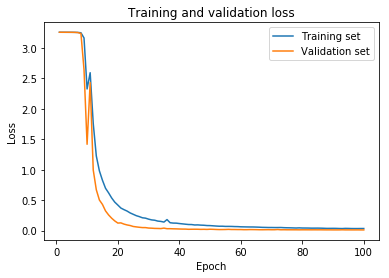

In [17]:
plt.subplot(111)
plt.plot(num_epochs, train_loss, label="Training set")
plt.plot(num_epochs, val_loss, label="Validation set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Figure 2:** The training and validation loss for 100 epochs

In **Figure 2**, the training and validation losses are decreasing in the same number of epochs. The spikes approximately between epochs 15 to 18 are due to the nature of momentum where it updates the gradient. However, from epoch 18 and onwards, the gradient updates have stabilized.

Next, let's take a look at training and validation accuracies.

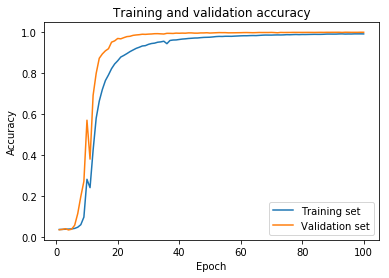

In [18]:
plt.subplot(111)
plt.plot(num_epochs, train_acc, label="Training set")
plt.plot(num_epochs, val_acc, label="Validation set")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

**Figure 3:** The training and validation accuracy for 100 epochs

In **Figure 3**, the training and validation accuracies show similar spikes approximately in epochs 15 to 18 as in **Figure 2**. This is a valid phenomenon because if the loss increases, the model makes more mistakes in its predictions.

Note that from **figures 2 and 3**, the model is not overfitting nor underfitting. The model's performance is the right balance for the bias-variance tradeoff problem. In addition, it is good to notice that once the model got around epochs 90 to 100, the model's training accuracy is not increasing any further. Instead, it fluctuates around 98%. This means that our model has converged.

Lastly, it is good to notice that the training and validation accuracies are **98.95%** and **99.74%**, respectively. Meanwhile, the training and validation losses are **0.0327** and **0.0097**, respectively.

## Test set performance

The dataset source has provided a separate test dataset. Before taking a look at the performance of our model, let's write a helper function to evaluate our model using test dataset.

In [43]:
def test_model(model, criterion, test_ds, batch_size=64):
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    test_losses = []
    test_accuracies = []
    
    # Ensure that model is in evaluation mode
    model.eval()
    
    print("[TEST] Running the model with test set...")
    
    with torch.no_grad():    
        for inputs, labels in tqdm_notebook(test_dl, desc="[TEST]"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            predictions = model(inputs)
            predictions = predictions.view(predictions.size(0) * predictions.size(1), -1)
            labels = labels.view(-1)
            loss = criterion(predictions, labels)

            test_losses.append(loss.item())
            test_accuracies.append(calculate_accuracy(predictions, labels).item())

    print("[TEST] Loss is {:.4f}".format(sum(test_losses) / len(test_dl)))
    print("[TEST] Accuracy is {:.4f}".format(sum(test_accuracies) / len(test_accuracies)))
    
    print("[TEST] Done!")

In [32]:
test_model(captcha_cnn_classifier, criterion, test_ds)

[TEST] Running the model with test set...



[TEST] Loss is 0.0087
[TEST] Accuracy is 0.9976
[TEST] Done!


This is a pretty impressive model performance! With an accuracy of **99.76%**, we can predict similar CAPTCHA images. Let's see it in action.

In [38]:
test_indices = np.arange(len(test_ds))
np.random.shuffle(test_indices)
test_index = test_indices[0]

# Ensure model is in evaluation mode
captcha_cnn_classifier.eval()

with torch.no_grad():
    input, label = test_ds[test_index]
    input, label = input.to(DEVICE), label.to(DEVICE)

    # Note that a batch size dimension is required since PyTorch works with batched tensors
    input = input.unsqueeze(0)

    prediction = captcha_cnn_classifier(input).squeeze()
    prediction = nn.LogSoftmax(dim=1)(prediction)
    prediction = torch.max(prediction, dim=1)[1].data

Let's see what `prediction` looks like:

In [39]:
print(prediction)

tensor([24, 11, 19], device='cuda:0')


Here are the characters representing this tensor:

In [40]:
print(vocab.convert_indices_to_sequences(prediction))

ylt


And here's the random image from the test dataset:

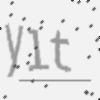

In [41]:
input_image = input.squeeze(0).cpu()
PILImageTransform = transforms.ToPILImage()

input_image = PILImageTransform(input_image)
input_image

Note that inputs 38 to 41 can be run multiple times to see the model's prediction given an image.

## Conclusion

In this project, I have implemented Garg's model architecture to predict the series of characters that are shown given a CAPTCHA image. The training and validation accuracies of **98.95%** and **99.74%**, respectively, shows how effective this model architecture is as a CAPTCHA solver. Lastly, the goal of removing character image segmentation in  the process allows prediction of distorted and overlapping characters with no issues.